requires earlier version of qiskit (ran with 0.23.4)

# Basics

In [ ]:
#!pip3 install qiskit
!pip3 install qiskit==0.23.4

import warnings
warnings.filterwarnings('ignore')
import qiskit
print(qiskit.__version__)
print(qiskit.__qiskit_version__['qiskit'])

import json
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.tools.jupyter import *
from qiskit import IBMQ, QuantumCircuit, transpile, schedule
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, SchedStyle
import qiskit.tools.jupyter
from scipy.optimize import curve_fit

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.pulse.library import Drag, Gaussian, GaussianSquare
from qiskit.pulse import (ControlChannel, DriveChannel, Schedule)
from qiskit.compiler import assemble

# Import Qiskit classes
from qiskit import Aer

import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

IBMQ.save_account('', overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub="", group="", project="")
backend_name = "casablanca"
backend = provider.get_backend('ibmq_'+backend_name)

backend_config = backend.configuration()
backend_defaults = backend.defaults()
inst_map = backend_defaults.instruction_schedule_map

# schedule.draw style
font_size = 8
my_style = SchedStyle(figsize=[8, 4], table_font_size=font_size, axis_font_size=1.5*font_size, label_font_size=font_size, icon_font_size=font_size, title_font_size=2*font_size)

# CZ gate optimization (please run)

First, we notice that although $CZ[0,1] = CZ[1,0]$, they are transpiled differently, which is related to how CNOT gates are implemented:

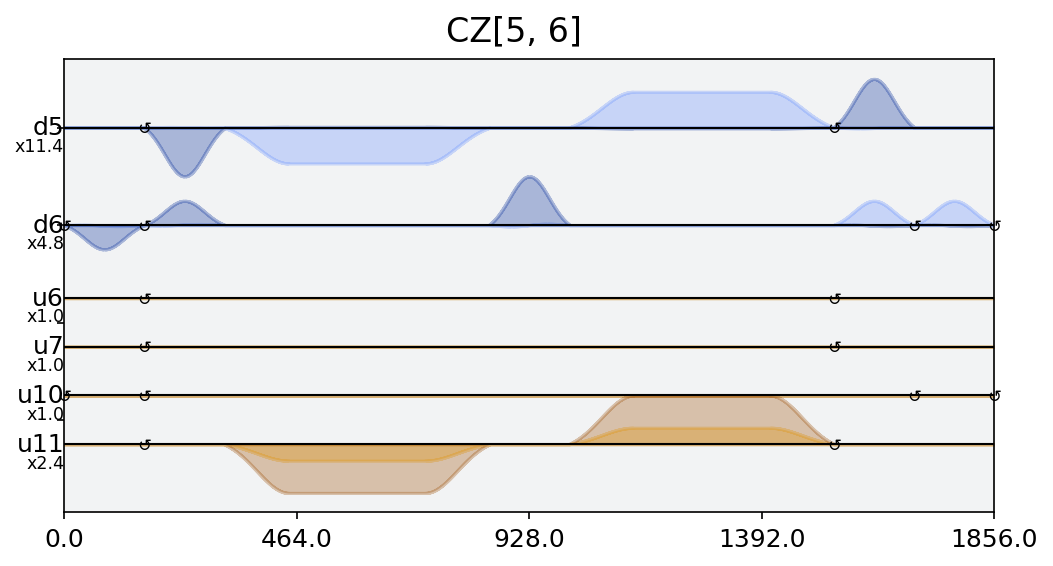

In [2]:
num_qubits = 7 # casablanca

circ = QuantumCircuit(num_qubits)
circ.cz(5,6)
sched = Schedule(name="CZ[5, 6]")
sched |= schedule(transpile(circ, backend), backend)
sched.draw(style=my_style)

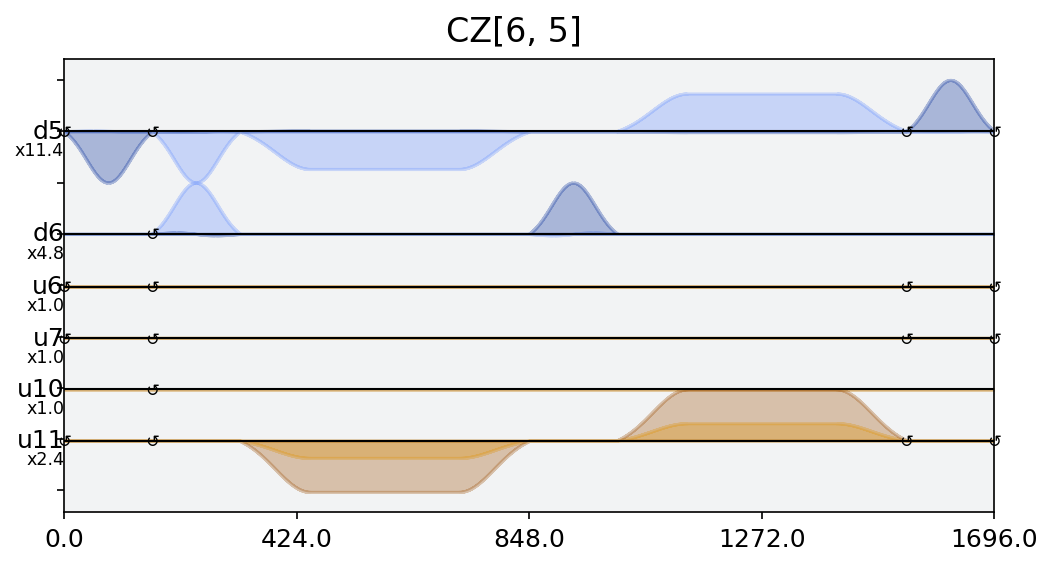

In [3]:
circ = QuantumCircuit(num_qubits)
circ.cz(6,5)
sched = Schedule(name="CZ[6, 5]")
sched |= schedule(transpile(circ, backend), backend)
sched.draw(style=my_style)

Using the shorter version of the CZ gate is preferable, because it requires 2 fewer 1q gates, and is 160 samples shorter.

However, it is still not the shortest possible decomposition of a CZ gate into cross-resonance (CR) pulses and 1q gates.

One can show that

    CZ =  IY(-1,2) * ZX(-1,4) * XI(1,1) * ZX(1,4) * IX(1,2) * ZI(-1,2) * XI(1,1) * IY(1,2)  (order: right-to-left)

To build this gate, we need to extract the calibrated CR pulses from the corresponding CNOT schedule, and add them together with 1q gates according to the above expression. The function below does that and returns the custom CZ schedule. One can easily perform QPT to show to that our custom schedule indeed behaves as a CZ gate.

In [4]:
def cz_from_cx(q0, q1):
    # pick the order of indices (q0, q1) that corresponds to the shorter CNOT[q0, q1]
    dur_0 = inst_map.get('cx', (q0, q1)).duration
    dur_1 = inst_map.get('cx', (q1, q0)).duration
    if dur_0 > dur_1:
        q0, q1 = q1, q0

    # determine CR pulse duration
    CNOT = inst_map.get('cx', (q0, q1))
    for i in range(len(CNOT.instructions)):
        if type(CNOT.instructions[i][1]) == qiskit.pulse.instructions.play.Play and str(CNOT.instructions[i][1].channel)[0:7] == "Control":
            cr_dur = CNOT.instructions[i][1].pulse.duration
            break

    # disassemble CNOT
    qc = QuantumCircuit(2)
    qc.cx(0, 1)
    qc_transpiled = transpile(qc, backend, initial_layout=[q0, q1])
    sched = schedule(qc_transpiled, backend)

    u_dur = 160 # 1q pulse duration
    # identify CR_p and CR_m pulses
    sched_crp = Schedule(name="crp")
    sched_crp |= sched.filter(time_ranges=[(u_dur,u_dur+cr_dur)])
    sched_crp = sched_crp.shift(-u_dur)

    sched_crm = Schedule(name="crm")
    sched_crm |= sched.filter(time_ranges=[(u_dur*2+cr_dur, u_dur*2+2*cr_dur)])
    sched_crm = sched_crm.shift(-u_dur*2-cr_dur)

    crp_gate = circuit.Gate('crp_gate', 2, [])
    crm_gate = circuit.Gate('crm_gate', 2, [])
    
    # put together the circuit for CZ gate
    cz_circ = QuantumCircuit(num_qubits)
    cz_circ.h(q1) # instead of IY(1,2)
    cz_circ.x(q0)
    cz_circ.rz(-np.pi/2, q0)
    cz_circ.rx(np.pi/2, q1)
    cz_circ.append(crp_gate, (q0, q1))
    cz_circ.x(q0)
    cz_circ.append(crm_gate, (q0, q1))
    cz_circ.h(q1) # instead of IY(-1,2)

    cz_circ.add_calibration(crp_gate, (q0, q1), sched_crp)
    cz_circ.add_calibration(crm_gate, (q0, q1), sched_crm)
    
    cz_sched = Schedule(name=f"CZ_custom[{q0}, {q1}]")
    cz_sched |= schedule(transpile(cz_circ, backend), backend)
    return cz_sched

In [5]:
cz_from_cx(6, 5).draw(style=my_style)

As a result, by using the custom CZ gate, one can noticeably reduce the duration and 1q gate count, improving both the gate fidelity (by having fewer gates) and overall circuit fidelity where this gate will be used (shorter circuit = less decoherence).

# Graph state circuit: CZ gate order optimization (please run)

Here is the default graph state circuit from the circuit library:

In [6]:
num_qubits = 7

# adjacency matrix for `ibmq_casablanca`
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

# function to count the number of 1q gates
def num_1q(sched): 
    counter = 0   
    for i in range(len(sched.instructions)):
        if type(sched.instructions[i][1]) == qiskit.pulse.instructions.play.Play and type(sched.instructions[i][1].pulse) == qiskit.pulse.library.parametric_pulses.Drag:
            counter += 1
    return counter

graph_state_circuit = QuantumCircuit(num_qubits)
graph_state_circuit = circuit_library.GraphState(adjmat)
display(graph_state_circuit.draw())
graph_sched = Schedule(name=f"Default graph state")
graph_sched |= schedule(transpile(graph_state_circuit, backend), backend)
display(graph_sched.draw(style=my_style, channels=(DriveChannel(0), DriveChannel(1), DriveChannel(2), DriveChannel(3), DriveChannel(4), DriveChannel(5), DriveChannel(6), ControlChannel(1), ControlChannel(2), ControlChannel(5), ControlChannel(8), ControlChannel(9), ControlChannel(11))))
print(f"\n1q gate count: {num_1q(graph_sched)}\n")

┌───┐                  
q_0: ┤ H ├─■────────────────
     ├───┤ │                
q_1: ┤ H ├─■──■──■──────────
     ├───┤    │  │          
q_2: ┤ H ├────■──┼──────────
     ├───┤       │          
q_3: ┤ H ├───────■──■───────
     ├───┤          │       
q_4: ┤ H ├──────────┼──■────
     ├───┤          │  │    
q_5: ┤ H ├──────────■──■──■─
     ├───┤                │ 
q_6: ┤ H ├────────────────■─
     └───┘


1q gate count: 35



It is clear that for the given topology of the ibmq_casablanca device, instead of being applied sequentially, the 6 CZ gates necessary to generate a graph state can be most efficiently arranged in 3 layes of 2 simulateneous CZ gates acting between two separate pairs of adjacent qubits, like so:

In [7]:
graph_state_circuit = QuantumCircuit(num_qubits)
qpairs = [(0, 1), (3, 5), (1, 2), (4, 5), (1, 3), (5,6)]
for i in range(num_qubits):
    graph_state_circuit.h(i)
    
for q0, q1 in qpairs:
    graph_state_circuit.cz(q0, q1)
graph_state_circuit.draw()

┌───┐         
q_0: ┤ H ├─■───────
     ├───┤ │       
q_1: ┤ H ├─■──■──■─
     ├───┤    │  │ 
q_2: ┤ H ├────■──┼─
     ├───┤       │ 
q_3: ┤ H ├─■─────■─
     ├───┤ │       
q_4: ┤ H ├─┼──■────
     ├───┤ │  │    
q_5: ┤ H ├─■──■──■─
     ├───┤       │ 
q_6: ┤ H ├───────■─
     └───┘

Because of fluctuating coherence properties of the device, the order of CZ gates that gives the highest overall graph state fidelity can change over time. To find the optimal order, we consider all 24 possible combinations to decide on the best candidate. The 24 options are presented below as an array of 24 lists, each consisting of 6 ordered pairs of CZ gates.



In [8]:
qpairs = []
for i in range(len(adjmat)):
  for j in range(i, len(adjmat)):
    if adjmat[i][j] == 1:
      qpairs.append((i, j))
print(f"All existing connections: {qpairs}")

All existing connections: [(0, 1), (1, 2), (1, 3), (3, 5), (4, 5), (5, 6)]


In [9]:
good_qpairs = []
for i1 in range(len(qpairs)):
  qpair_1 = qpairs[i1]
  qpairs_pick_2 = [link for link in qpairs[i1:] if (qpair_1[0] not in link) and (qpair_1[1] not in link)]
  for i2 in range(len(qpairs_pick_2)):
    qpair_2 = qpairs_pick_2[i2]
    qpairs_left_2 = [link for link in qpairs if link != qpair_1 and link != qpair_2]
    if len(qpairs_left_2) > 0:
      for i3 in range(len(qpairs_left_2)):
        qpair_3 = qpairs_left_2[i3]
        qpairs_pick_4 = [link for link in qpairs_left_2[i3:] if (qpair_3[0] not in link) and (qpair_3[1] not in link)]
        for i4 in range(len(qpairs_pick_4)):
          qpair_4 = qpairs_pick_4[i4]
          qpairs_left_4 = [link for link in qpairs_left_2 if link != qpair_3 and link != qpair_4]
          if len(qpairs_left_4) > 0:
            for i5 in range(len(qpairs_left_4)):
              qpair_5 = qpairs_left_4[i5]
              qpairs_pick_6 = [link for link in qpairs_left_4[i5:] if (qpair_5[0] not in link) and (qpair_5[1] not in link)]
              for i6 in range(len(qpairs_pick_6)):
                qpair_6 = qpairs_pick_6[i6]
                q_sequence = [qpair_1, qpair_2, qpair_3, qpair_4, qpair_5, qpair_6]
                good_qpairs.append(q_sequence)
print(f"all possible 3-layer combinations ({len(good_qpairs)} total):")
good_qpairs

all possible 3-layer combinations (24 total):


[[(0, 1), (3, 5), (1, 2), (4, 5), (1, 3), (5, 6)],
 [(0, 1), (3, 5), (1, 2), (5, 6), (1, 3), (4, 5)],
 [(0, 1), (3, 5), (1, 3), (4, 5), (1, 2), (5, 6)],
 [(0, 1), (3, 5), (1, 3), (5, 6), (1, 2), (4, 5)],
 [(0, 1), (4, 5), (1, 2), (3, 5), (1, 3), (5, 6)],
 [(0, 1), (4, 5), (1, 3), (5, 6), (1, 2), (3, 5)],
 [(0, 1), (5, 6), (1, 2), (3, 5), (1, 3), (4, 5)],
 [(0, 1), (5, 6), (1, 3), (4, 5), (1, 2), (3, 5)],
 [(1, 2), (3, 5), (0, 1), (4, 5), (1, 3), (5, 6)],
 [(1, 2), (3, 5), (0, 1), (5, 6), (1, 3), (4, 5)],
 [(1, 2), (3, 5), (1, 3), (4, 5), (0, 1), (5, 6)],
 [(1, 2), (3, 5), (1, 3), (5, 6), (0, 1), (4, 5)],
 [(1, 2), (4, 5), (0, 1), (3, 5), (1, 3), (5, 6)],
 [(1, 2), (4, 5), (1, 3), (5, 6), (0, 1), (3, 5)],
 [(1, 2), (5, 6), (0, 1), (3, 5), (1, 3), (4, 5)],
 [(1, 2), (5, 6), (1, 3), (4, 5), (0, 1), (3, 5)],
 [(1, 3), (4, 5), (0, 1), (3, 5), (1, 2), (5, 6)],
 [(1, 3), (4, 5), (0, 1), (5, 6), (1, 2), (3, 5)],
 [(1, 3), (4, 5), (1, 2), (3, 5), (0, 1), (5, 6)],
 [(1, 3), (4, 5), (1, 2), (5, 6

Each of these 24 sequences of CZ gates fixes the order of CR pulses in the graph state circuit. However, by swapping indices inside any of the given sequence of ZC gates, e.g.

    [(2, 1), (3, 5), (1, 3), (4, 5), (0, 1), (5, 6)] --> [(1, 2), (5, 3), (1, 3), (4, 5), (1, 0), (5, 6)]

we can generate a different quantum circuit that, after a transpiler pass, will generally have a different duration and number of 1q gates.

For example, compare the circuits corresponding to the above example:

┌───┐         
q_0: ┤ H ├───────■─
     ├───┤       │ 
q_1: ┤ H ├─■──■──■─
     ├───┤ │  │    
q_2: ┤ H ├─■──┼────
     ├───┤    │    
q_3: ┤ H ├─■──■────
     ├───┤ │       
q_4: ┤ H ├─┼──■────
     ├───┤ │  │    
q_5: ┤ H ├─■──■──■─
     ├───┤       │ 
q_6: ┤ H ├───────■─
     └───┘


1q gate count: 41



┌───┐         
q_0: ┤ H ├───────■─
     ├───┤       │ 
q_1: ┤ H ├─■──■──■─
     ├───┤ │  │    
q_2: ┤ H ├─■──┼────
     ├───┤    │    
q_3: ┤ H ├─■──■────
     ├───┤ │       
q_4: ┤ H ├─┼──■────
     ├───┤ │  │    
q_5: ┤ H ├─■──■──■─
     ├───┤       │ 
q_6: ┤ H ├───────■─
     └───┘

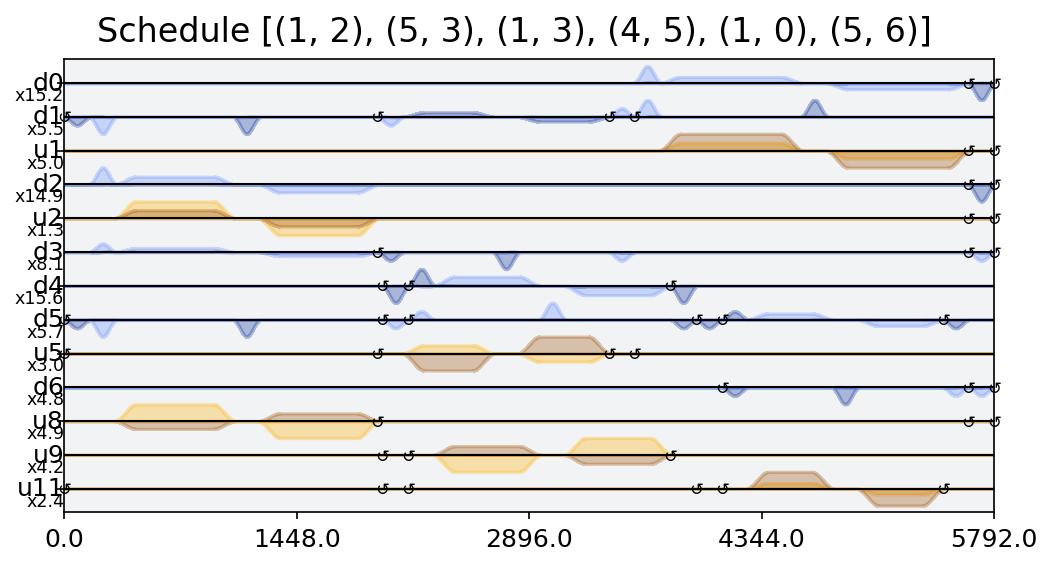


1q gate count: 33



In [10]:
graph_state_circuit = QuantumCircuit(num_qubits)
qpairs = [(2, 1), (3, 5), (1, 3), (4, 5), (0, 1), (5, 6)]
for i in range(num_qubits):
    graph_state_circuit.h(i)
    
for q0, q1 in qpairs:
    graph_state_circuit.cz(q0, q1)
display(graph_state_circuit.draw())
graph_sched = Schedule(name=f"Schedule {qpairs}")
graph_sched |= schedule(transpile(graph_state_circuit, backend), backend)
display(graph_sched.draw(style=my_style, channels=(DriveChannel(0), DriveChannel(1), DriveChannel(2), DriveChannel(3), DriveChannel(4), DriveChannel(5), DriveChannel(6), ControlChannel(1), ControlChannel(2), ControlChannel(5), ControlChannel(8), ControlChannel(9), ControlChannel(11))))
print(f"\n1q gate count: {num_1q(graph_sched)}\n")

graph_state_circuit = QuantumCircuit(num_qubits)
qpairs = [(1, 2), (5, 3), (1, 3), (4, 5), (1, 0), (5, 6)]
for i in range(num_qubits):
    graph_state_circuit.h(i)
    
for q0, q1 in qpairs:
    graph_state_circuit.cz(q0, q1)
display(graph_state_circuit.draw())
graph_sched = Schedule(name=f"Schedule {qpairs}")
graph_sched |= schedule(transpile(graph_state_circuit, backend), backend)
display(graph_sched.draw(style=my_style, channels=(DriveChannel(0), DriveChannel(1), DriveChannel(2), DriveChannel(3), DriveChannel(4), DriveChannel(5), DriveChannel(6), ControlChannel(1), ControlChannel(2), ControlChannel(5), ControlChannel(8), ControlChannel(9), ControlChannel(11))))
print(f"\n1q gate count: {num_1q(graph_sched)}\n")

As you can see, the pulse schedules are vastly different (6432 vs. 5792 samples, 41 vs. 33 one-qubit gates), despite the fact that the circuits look identical. Naturally, one would expect that a shorter schedule with fewer gates would have a higher fidelity.

This observation mandates that for every given sequence of CZ gates, we must also find the shortest schedule possible with the lowest number of gates. One can show that for each of 24 possible 3-layer CZ gate sequences, there are 63 different permutations of indices within each qubit pair (without affecting the order of CZ gates in the circuit). Iterating over all of them, produces the optimal version of the circuit for each of the 24 possible CZ gate orderings.

In [11]:
# Commented out to prevent running accidentally (takes a few minutes)
'''
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

def q_swaps_sequence(q_sequence):
    all_seqs = []
    # all possible combinations of CZ direction flips for a given CZ gate sequence
    subsets = list(powerset(range(len(q_sequence))))
    for subset in subsets:
        q_sequence_copy = q_sequence.copy()
        if len(subset) > 0:
            for j in subset:
                q_sequence_copy[j] = q_sequence_copy[j][::-1]
            all_seqs.append(q_sequence_copy)
    return all_seqs

num_q = []
durs = []
opt_seqs = []
for i, q_sequence in enumerate(good_qpairs):
    print(f"{i + 1}/{len(good_qpairs)}")
    num_q_min = 99
    dur_min = 99999
    best_seq = []
    q_swaps_all = q_swaps_sequence(q_sequence)
    for id, swap_sequence in enumerate(q_swaps_all):
        graph_state_circuit = QuantumCircuit(num_qubits)
        for j in range(num_qubits):
            graph_state_circuit.h(j)
        for q0, q1 in swap_sequence:
            graph_state_circuit.cz(q0, q1)
        graph_sched = schedule(transpile(graph_state_circuit, backend), backend)        
        dur_id = graph_sched.duration
        num_q_id = num_1q(graph_sched)
        if num_q_id <= num_q_min and dur_id <= dur_min:
            num_q_min = num_q_id
            dur_min = dur_id
            best_seq = swap_sequence
    num_q.append(num_q_min)
    durs.append(dur_min)
    opt_seqs.append(best_seq)
print(f"\ncount_1q = {num_q}\ndurations = {durs}\noptimal_sequence = {opt_seqs}")
'''

'\nfrom itertools import chain, combinations\n\ndef powerset(iterable):\n    s = list(iterable)\n    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))\n\ndef q_swaps_sequence(q_sequence):\n    all_seqs = []\n    # all possible combinations of CZ direction flips for a given CZ gate sequence\n    subsets = list(powerset(range(len(q_sequence))))\n    for subset in subsets:\n        q_sequence_copy = q_sequence.copy()\n        if len(subset) > 0:\n            for j in subset:\n                q_sequence_copy[j] = q_sequence_copy[j][::-1]\n            all_seqs.append(q_sequence_copy)\n    return all_seqs\n\nnum_q = []\ndurs = []\nopt_seqs = []\nfor i, q_sequence in enumerate(good_qpairs):\n    print(f"{i + 1}/{len(good_qpairs)}")\n    num_q_min = 99\n    dur_min = 99999\n    best_seq = []\n    q_swaps_all = q_swaps_sequence(q_sequence)\n    for id, swap_sequence in enumerate(q_swaps_all):\n        graph_state_circuit = QuantumCircuit(num_qubits)\n        for j in ran

In [12]:
count_1q = [29, 29, 29, 29, 29, 29, 27, 27, 29, 29, 29, 29, 29, 29, 27, 27, 29, 29, 29, 29, 27, 27, 27, 27]
durations = [5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792, 5792]
optimal_sequence = [[(1, 0), (5, 3), (1, 2), (5, 4), (3, 1), (6, 5)], [(1, 0), (5, 3), (1, 2), (6, 5), (3, 1), (5, 4)], [(1, 0), (5, 3), (1, 3), (5, 4), (1, 2), (6, 5)], [(1, 0), (5, 3), (1, 3), (6, 5), (1, 2), (5, 4)], [(1, 0), (5, 4), (1, 2), (5, 3), (3, 1), (6, 5)], [(1, 0), (5, 4), (1, 3), (6, 5), (1, 2), (5, 3)], [(1, 0), (6, 5), (1, 2), (5, 3), (3, 1), (5, 4)], [(1, 0), (6, 5), (1, 3), (5, 4), (1, 2), (5, 3)], [(1, 2), (5, 3), (1, 0), (5, 4), (3, 1), (6, 5)], [(1, 2), (5, 3), (1, 0), (6, 5), (3, 1), (5, 4)], [(1, 2), (5, 3), (1, 3), (5, 4), (1, 0), (6, 5)], [(1, 2), (5, 3), (1, 3), (6, 5), (1, 0), (5, 4)], [(1, 2), (5, 4), (1, 0), (5, 3), (3, 1), (6, 5)], [(1, 2), (5, 4), (1, 3), (6, 5), (1, 0), (5, 3)], [(1, 2), (6, 5), (1, 0), (5, 3), (3, 1), (5, 4)], [(1, 2), (6, 5), (1, 3), (5, 4), (1, 0), (5, 3)], [(3, 1), (5, 4), (1, 0), (5, 3), (1, 2), (6, 5)], [(3, 1), (5, 4), (1, 0), (6, 5), (1, 2), (5, 3)], [(3, 1), (5, 4), (1, 2), (5, 3), (1, 0), (6, 5)], [(3, 1), (5, 4), (1, 2), (6, 5), (1, 0), (5, 3)], [(3, 1), (6, 5), (1, 0), (5, 3), (1, 2), (5, 4)], [(3, 1), (6, 5), (1, 0), (5, 4), (1, 2), (5, 3)], [(3, 1), (6, 5), (1, 2), (5, 3), (1, 0), (5, 4)], [(3, 1), (6, 5), (1, 2), (5, 4), (1, 0), (5, 3)]]

The 3 lists generated above, 24 elements each, give the 1q gate count, total circuit duration, and the optimal qubit index pairs, correspondingly. The shortest possible duration, using default CZ gates, is 5792 samples for all 24 circuits, with 1q gate counts of either 27 or 29. This is already a major impromevent over 11712 samples and 35 1q gates for the default graph state circuit generated by `circuit_library.GraphState(adjmat)`.

We will now show that the circuit can be further optimized down to 5472 shots and, most importantly, just 21-23 one-qubit gates, by employing the custom CZ gate that we defined in the previous Section.

To achieve that, we will once again rely on the standard transpiler to reduce the number of 1q gates for us. To maximize that, we split the custom CZ gate as follows. Instead of converting into a custom pulse schedule the entire sequence of gates,

In [13]:
'''
cz_circ = QuantumCircuit(num_qubits)
cz_circ.h(q1)
cz_circ.x(q0)
cz_circ.rz(-np.pi/2, q0)
cz_circ.rx(np.pi/2, q1)
#
cz_circ.append(crp_gate, (q0, q1))
cz_circ.x(q0)
cz_circ.append(crm_gate, (q0, q1))
#
cz_circ.h(q1)        
'''             

'\ncz_circ = QuantumCircuit(num_qubits)\ncz_circ.h(q1)\ncz_circ.x(q0)\ncz_circ.rz(-np.pi/2, q0)\ncz_circ.rx(np.pi/2, q1)\n#\ncz_circ.append(crp_gate, (q0, q1))\ncz_circ.x(q0)\ncz_circ.append(crm_gate, (q0, q1))\n#\ncz_circ.h(q1)        \n'

we will define the block

In [14]:
'''
cz_circ.append(crp_gate, (q0, q1))
cz_circ.x(q0)
cz_circ.append(crm_gate, (q0, q1))
'''

'\ncz_circ.append(crp_gate, (q0, q1))\ncz_circ.x(q0)\ncz_circ.append(crm_gate, (q0, q1))\n'

separately, call it `cr2`, and convert it into a schedule by using the following function, while the remaining gates will be added into our graph state circuit directly, allowing the transpiler to better optimize the circuit:

In [15]:
def cr2_from_cx(q0, q1):
    # pick the order of indices (q0, q1) that corresponds to the shorter CNOT[q0, q1]
    dur_0 = inst_map.get('cx', (q0, q1)).duration
    dur_1 = inst_map.get('cx', (q1, q0)).duration
    if dur_0 > dur_1:
        q0, q1 = q1, q0

    # determine CR pulse duration
    CNOT = inst_map.get('cx', (q0, q1))
    for i in range(len(CNOT.instructions)):
        if type(CNOT.instructions[i][1]) == qiskit.pulse.instructions.play.Play and str(CNOT.instructions[i][1].channel)[0:7] == "Control":
            cr_dur = CNOT.instructions[i][1].pulse.duration
            break

    # disassemble CNOT
    qc = QuantumCircuit(2)
    qc.cx(0, 1)
    qc_transpiled = transpile(qc, backend, initial_layout=[q0, q1])
    sched = schedule(qc_transpiled, backend)

    u_dur = 160 # 1q pulse duration
    # identify CR_p and CR_m pulses
    sched_crp = Schedule(name="crp")
    sched_crp |= sched.filter(time_ranges=[(u_dur,u_dur+cr_dur)])
    sched_crp = sched_crp.shift(-u_dur)

    sched_crm = Schedule(name="crm")
    sched_crm |= sched.filter(time_ranges=[(u_dur*2+cr_dur, u_dur*2+2*cr_dur)])
    sched_crm = sched_crm.shift(-u_dur*2-cr_dur)

    crp_gate = circuit.Gate('crp_gate', 2, [])
    crm_gate = circuit.Gate('crm_gate', 2, [])
    
    # put together the circuit for CZ gate
    cr2_circ = QuantumCircuit(num_qubits)
    #cr2_circ.h(q1)                       - added explicitly in the graph state circuit
    #cr2_circ.x(q0)                       - added explicitly in the graph state circuit
    #cr2_circ.rz(-np.pi/2, q0)            - added explicitly in the graph state circuit
    #cr2_circ.rx(np.pi/2, q1)             - added explicitly in the graph state circuit
    cr2_circ.append(crp_gate, (q0, q1))
    cr2_circ.x(q0)
    cr2_circ.append(crm_gate, (q0, q1))
    #cr2_circ.h(q1)                       - added explicitly in the graph state circuit

    cr2_circ.add_calibration(crp_gate, (q0, q1), sched_crp)
    cr2_circ.add_calibration(crm_gate, (q0, q1), sched_crm)
    
    cr2_sched = Schedule(name=f"cr2_block[{q0}, {q1}]")
    cr2_sched |= schedule(transpile(cr2_circ, backend), backend)
    return cr2_sched

Calculate 1q gate counts and circuit durations using custom CZ gates:

In [16]:
# Commented out to prevent running accidentally (takes a few minutes)
'''
num_q = []
durs = []
opt_seqs = []
for i, q_sequence in enumerate(good_qpairs):
    print(f"{i + 1}/{len(good_qpairs)}")
    graph_state_circuit = QuantumCircuit(num_qubits)
    for j in range(num_qubits):
        graph_state_circuit.h(j)
    for q0, q1 in q_sequence:         
        # custom CZ gates are defined in the direction of the shorter CNOT
        dur_0 = inst_map.get('cx', (q0, q1)).duration
        dur_1 = inst_map.get('cx', (q1, q0)).duration
        if dur_0 > dur_1:
            q0, q1 = q1, q0

        graph_state_circuit.h(q1)
        graph_state_circuit.x(q0)            
        graph_state_circuit.rz(-np.pi/2, q0)
        graph_state_circuit.rx(np.pi/2, q1)
        graph_state_circuit.cz(q0, q1)      # this cz is redefined as cr2
        graph_state_circuit.h(q1) 
        
        graph_state_circuit.add_calibration('cz', [q0, q1], cr2_from_cx(q0, q1))

    graph_sched = schedule(transpile(graph_state_circuit, backend), backend) 
    num_q_id = num_1q(graph_sched)       
    dur_id = graph_sched.duration
    num_q.append(num_q_id)
    durs.append(dur_id)
    opt_seqs.append(q_sequence)
print(f"\ncount_1q = {num_q}\ndurations = {durs}\noptimal_sequence = {opt_seqs}")
'''

'\nnum_q = []\ndurs = []\nopt_seqs = []\nfor i, q_sequence in enumerate(good_qpairs):\n    print(f"{i + 1}/{len(good_qpairs)}")\n    graph_state_circuit = QuantumCircuit(num_qubits)\n    for j in range(num_qubits):\n        graph_state_circuit.h(j)\n    for q0, q1 in q_sequence:         \n        # custom CZ gates are defined in the direction of the shorter CNOT\n        dur_0 = inst_map.get(\'cx\', (q0, q1)).duration\n        dur_1 = inst_map.get(\'cx\', (q1, q0)).duration\n        if dur_0 > dur_1:\n            q0, q1 = q1, q0\n\n        graph_state_circuit.h(q1)\n        graph_state_circuit.x(q0)            \n        graph_state_circuit.rz(-np.pi/2, q0)\n        graph_state_circuit.rx(np.pi/2, q1)\n        graph_state_circuit.cz(q0, q1)      # this cz is redefined as cr2\n        graph_state_circuit.h(q1) \n        \n        graph_state_circuit.add_calibration(\'cz\', [q0, q1], cr2_from_cx(q0, q1))\n\n    graph_sched = schedule(transpile(graph_state_circuit, backend), backend) \n   

In [17]:
count_1q = [23, 22, 22, 21, 23, 22, 22, 22, 23, 22, 22, 21, 23, 22, 22, 22, 23, 22, 23, 22, 22, 22, 22, 22]
durations = [5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472, 5472]
optimal_sequence = [[(0, 1), (3, 5), (1, 2), (4, 5), (1, 3), (5, 6)], [(0, 1), (3, 5), (1, 2), (5, 6), (1, 3), (4, 5)], [(0, 1), (3, 5), (1, 3), (4, 5), (1, 2), (5, 6)], [(0, 1), (3, 5), (1, 3), (5, 6), (1, 2), (4, 5)], [(0, 1), (4, 5), (1, 2), (3, 5), (1, 3), (5, 6)], [(0, 1), (4, 5), (1, 3), (5, 6), (1, 2), (3, 5)], [(0, 1), (5, 6), (1, 2), (3, 5), (1, 3), (4, 5)], [(0, 1), (5, 6), (1, 3), (4, 5), (1, 2), (3, 5)], [(1, 2), (3, 5), (0, 1), (4, 5), (1, 3), (5, 6)], [(1, 2), (3, 5), (0, 1), (5, 6), (1, 3), (4, 5)], [(1, 2), (3, 5), (1, 3), (4, 5), (0, 1), (5, 6)], [(1, 2), (3, 5), (1, 3), (5, 6), (0, 1), (4, 5)], [(1, 2), (4, 5), (0, 1), (3, 5), (1, 3), (5, 6)], [(1, 2), (4, 5), (1, 3), (5, 6), (0, 1), (3, 5)], [(1, 2), (5, 6), (0, 1), (3, 5), (1, 3), (4, 5)], [(1, 2), (5, 6), (1, 3), (4, 5), (0, 1), (3, 5)], [(1, 3), (4, 5), (0, 1), (3, 5), (1, 2), (5, 6)], [(1, 3), (4, 5), (0, 1), (5, 6), (1, 2), (3, 5)], [(1, 3), (4, 5), (1, 2), (3, 5), (0, 1), (5, 6)], [(1, 3), (4, 5), (1, 2), (5, 6), (0, 1), (3, 5)], [(1, 3), (5, 6), (0, 1), (3, 5), (1, 2), (4, 5)], [(1, 3), (5, 6), (0, 1), (4, 5), (1, 2), (3, 5)], [(1, 3), (5, 6), (1, 2), (3, 5), (0, 1), (4, 5)], [(1, 3), (5, 6), (1, 2), (4, 5), (0, 1), (3, 5)]]

# Experiment with dynamical decoupling

Dynamical decoupling is a technique that allows to reduce dephasing of idling qubits by inserting identity gates to better preserve coherence. To implement this, a sequence of XYXY gate identities, called XY4, is inserted during the intervals of time when the qubit is likely to suffer from dephasing. For the graph state circuits considered here, the dynamical decoupling protocol that we use is demonstraded below. Note that in order for transpiler not to cancel out the inserted XY4 identities, we insert them into the graph state circuit as custom pulse sequences.

To demonstrate DD, we pick one of the above 24 optimized circuits at random. Ideally, one would test which of the 24 gives produces the graphs state of highest fidelity, however I was unable to perform these experiments due to problems with the casablanca device (e.g., reported TLS issues with Q4 around the end of March, and then with Q1 12-16 April), as well as because of the unsportsmanship behavior of one of the competitors who submitted 1000s of jobs and effectively blocked others from running experiments for days.

For the purpose of this solution, we will take the following sequence of custom CZ gates:

In [18]:
qpairs = [(1, 3), (5, 6), (0, 1), (3, 5), (1, 2), (4, 5)]

In [19]:
# extract X pulse parameters for each qubit
for qubit in range(num_qubits):
    sched = inst_map.get('x', qubits=qubit)
    x_dur = sched.instructions[0][1].pulse.duration
    x_sigma = sched.instructions[0][1].pulse.sigma
    x_amp = sched.instructions[0][1].pulse.amp
    x_beta = sched.instructions[0][1].pulse.beta
    with pulse.build() as x_sched:
        pulse.play(pulse.Drag(duration=x_dur, 
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=x_beta), pulse.DriveChannel(qubit))
    with pulse.build() as y_sched:
        pulse.play(pulse.Drag(duration=x_dur, 
                              amp=1j*x_amp,
                              sigma=x_sigma,
                              beta=x_beta), pulse.DriveChannel(qubit))
    if inst_map.has('Xp', qubits=(qubit, )):
        inst_map.remove('Xp', qubits=(qubit, ))
    inst_map.add('Xp', qubits=(qubit, ), schedule=x_sched)
    if inst_map.has('Yp', qubits=(qubit, )):
        inst_map.remove('Yp', qubits=(qubit, ))
    inst_map.add('Yp', qubits=(qubit, ), schedule=y_sched)

# XY4 schedule for Q0
qubit = 0
n_rep = 3
with pulse.build() as sched_xy4p_0:
    with pulse.align_sequential():
      for i in range(n_rep):
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
if inst_map.has('XY4p', qubits=(qubit, )):
    inst_map.remove('XY4p', qubits=(qubit, ))
inst_map.add('XY4p', qubits=(qubit, ), schedule=sched_xy4p_0)

# XY4 schedule for Q3
qubit = 3
n_rep = 3
with pulse.build() as sched_xy4p_3:
    with pulse.align_sequential():
      for i in range(n_rep):
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
if inst_map.has('XY4p', qubits=(qubit, )):
    inst_map.remove('XY4p', qubits=(qubit, ))
inst_map.add('XY4p', qubits=(qubit, ), schedule=sched_xy4p_3)

# XY4 schedule for Q6
qubit = 6
n_rep = 6
with pulse.build() as sched_xy4p_6:
    with pulse.align_sequential():
      for i in range(n_rep):
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
        pulse.call(inst_map.get('Xp', qubits=qubit))
        pulse.call(inst_map.get('Yp', qubits=qubit))
if inst_map.has('XY4p', qubits=(qubit, )):
    inst_map.remove('XY4p', qubits=(qubit, ))
inst_map.add('XY4p', qubits=(qubit, ), schedule=sched_xy4p_6)

In [20]:
def create_graph_state(ver='default', qpairs=None):
    
    # default graph state circuit
    if ver == 'default':
        graph_state_circuit = circuit_library.GraphState(adjmat)

    # graph state circuit with default CZ in to right order
    elif ver == 'clifford':               
        graph_state_circuit = QuantumCircuit(num_qubits)        
        for i in range(num_qubits):
            graph_state_circuit.h(i)   
        for (q0, q1) in qpairs:    
            graph_state_circuit.cz(q0, q1)

    # custom graph state circuit without DD
    elif ver == 'custom':               
        graph_state_circuit = QuantumCircuit(num_qubits)        
        for i in range(num_qubits):
            graph_state_circuit.h(i)   
        for (q0, q1) in qpairs:            
            # custom CZ gates are defined in the direction of the shorter CNOT
            dur_0 = inst_map.get('cx', (q0, q1)).duration
            dur_1 = inst_map.get('cx', (q1, q0)).duration
            if dur_0 > dur_1:
                q0, q1 = q1, q0

            graph_state_circuit.h(q1)
            graph_state_circuit.x(q0)            
            graph_state_circuit.rz(-np.pi/2, q0)
            graph_state_circuit.rx(np.pi/2, q1)
            graph_state_circuit.cz(q0, q1)
            graph_state_circuit.h(q1) 
        #for (q0, q1) in qpairs:
            graph_state_circuit.add_calibration('cz', [q0, q1], cr2_from_cx(q0, q1))

    # custom graph state circuit with DD
    elif ver == 'DD':               
        graph_state_circuit = QuantumCircuit(num_qubits) 

        for i in range(num_qubits):
            graph_state_circuit.h(i)  
        for (q0, q1) in qpairs[0:2]:            
            # custom CZ gates are defined in the direction of the shorter CNOT
            dur_0 = inst_map.get('cx', (q0, q1)).duration
            dur_1 = inst_map.get('cx', (q1, q0)).duration
            if dur_0 > dur_1:
                q0, q1 = q1, q0
            graph_state_circuit.h(q1)
            graph_state_circuit.x(q0)            
            graph_state_circuit.rz(-np.pi/2, q0)
            graph_state_circuit.rx(np.pi/2, q1)
            graph_state_circuit.cz(q0, q1)
            graph_state_circuit.h(q1)
            graph_state_circuit.add_calibration('cz', [q0, q1], cr2_from_cx(q0, q1))
             
        for (q0, q1) in qpairs[2:4]:  
            graph_state_circuit.cz(q0, q1) # using default CZ to insert XY4 for Q0 and Q3

        for (q0, q1) in qpairs[4:6]:            
            # custom CZ gates are defined in the direction of the shorter CNOT
            dur_0 = inst_map.get('cx', (q0, q1)).duration
            dur_1 = inst_map.get('cx', (q1, q0)).duration
            if dur_0 > dur_1:
                q0, q1 = q1, q0
            graph_state_circuit.h(q1)
            graph_state_circuit.x(q0)            
            graph_state_circuit.rz(-np.pi/2, q0)
            graph_state_circuit.rx(np.pi/2, q1)
            graph_state_circuit.cz(q0, q1)
            graph_state_circuit.h(q1)
            graph_state_circuit.add_calibration('cz', [q0, q1], cr2_from_cx(q0, q1))

        # insert DD sequences as redefined identities
        for q_DD in [0, 3, 6]:
            graph_state_circuit.id(q_DD)  
            graph_state_circuit.add_calibration('id', [0], sched_xy4p_0)
            graph_state_circuit.add_calibration('id', [3], sched_xy4p_3)
            graph_state_circuit.add_calibration('id', [6], sched_xy4p_6)     
    return graph_state_circuit

Because we are using non-Clifford gates in this circuit, we define a separate graphs state circuit `state_circuit0` out of Cliffords used to create generators and stabilizers.

┌───┐                            ┌───┐                    
q_0: ┤ H ├──────────────────────────■─┤ I ├────────────────────
     ├───┤┌───┐┌─────────┐    ┌───┐ │ ├───┤┌──────────┐        
q_1: ┤ H ├┤ H ├┤ RX(π/2) ├──■─┤ H ├─■─┤ X ├┤ RZ(-π/2) ├─■──────
     ├───┤├───┤├─────────┤  │ └───┘   └───┘└──────────┘ │ ┌───┐
q_2: ┤ H ├┤ H ├┤ RX(π/2) ├──┼───────────────────────────■─┤ H ├
     ├───┤├───┤├─────────┴┐ │         ┌───┐               └───┘
q_3: ┤ H ├┤ X ├┤ RZ(-π/2) ├─■───────■─┤ I ├────────────────────
     ├───┤├───┤├─────────┬┘         │ └───┘               ┌───┐
q_4: ┤ H ├┤ H ├┤ RX(π/2) ├──────────┼───────────────────■─┤ H ├
     ├───┤├───┤├─────────┤    ┌───┐ │ ┌───┐┌──────────┐ │ └───┘
q_5: ┤ H ├┤ H ├┤ RX(π/2) ├──■─┤ H ├─■─┤ X ├┤ RZ(-π/2) ├─■──────
     ├───┤├───┤├─────────┴┐ │ ├───┤   └───┘└──────────┘        
q_6: ┤ H ├┤ X ├┤ RZ(-π/2) ├─■─┤ I ├────────────────────────────
     └───┘└───┘└──────────┘   └───┘

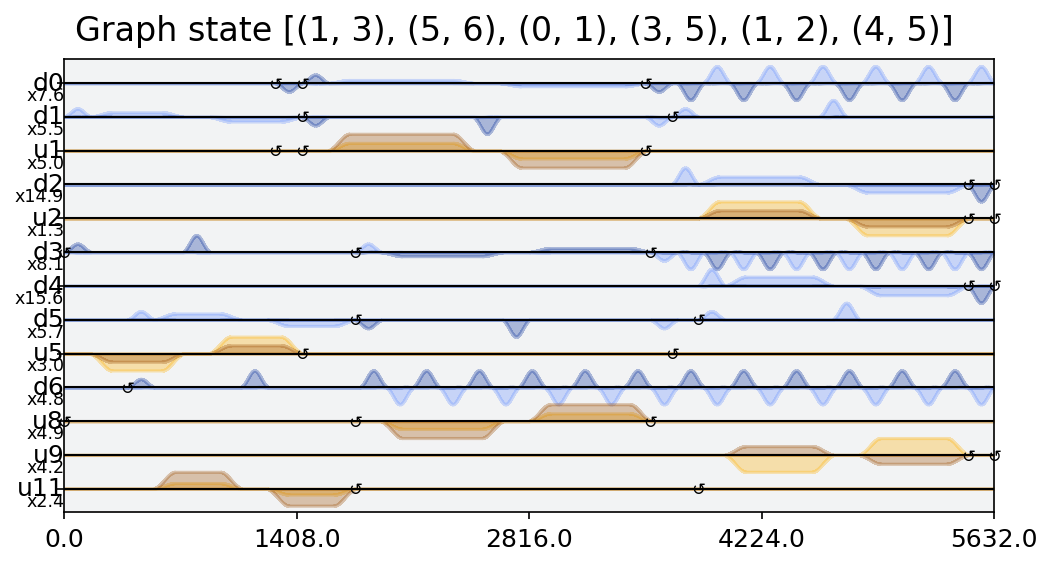

In [21]:
state_circuit0 = create_graph_state("clifford", qpairs) # auxiliary circuit for generators
#state_circuit = create_graph_state("default", qpairs) # for testing
state_circuit = create_graph_state("DD", qpairs)

display(state_circuit.draw(style=my_style))

graph_sched = Schedule(name=f"Graph state {qpairs}")
graph_sched |= schedule(transpile(state_circuit, backend), backend)
#print(f"\n1q gate count: {num_1q(graph_sched)}")
graph_sched.draw(style=my_style, channels=(DriveChannel(0), DriveChannel(1), DriveChannel(2), DriveChannel(3), DriveChannel(4), DriveChannel(5), DriveChannel(6), ControlChannel(1), ControlChannel(2), ControlChannel(5), ControlChannel(8), ControlChannel(9), ControlChannel(11)))

In [22]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [23]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit0).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit0)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

In [24]:
## compute_stabilizer_group(state_circuit)
Stabilizers: ['+IIIIIII', '-IIIIIZX', '-IIIIYIX', '+IIIIYZI', '-IIIZXXZ', '+IIIZXYY', '-IIIZZXY', '-IIIZZYZ', '-IIYXIIX', '+IIYXIZI', '+IIYXYII', '-IIYXYZX', '-IIYYXXY', '-IIYYXYZ', '+IIYYZXZ', '-IIYYZYY', '-IZIXIIX', '+IZIXIZI', '+IZIXYII', '-IZIXYZX', '-IZIYXXY', '-IZIYXYZ', '+IZIYZXZ', '-IZIYZYY', '+IZYIIII', '-IZYIIZX', '-IZYIYIX', '+IZYIYZI', '-IZYZXXZ', '+IZYZXYY', '-IZYZZXY', '-IZYZZYZ', '+XIIXIIX', '-XIIXIZI', '-XIIXYII', '+XIIXYZX', '+XIIYXXY', '+XIIYXYZ', '-XIIYZXZ', '+XIIYZYY', '-XIYIIII', '+XIYIIZX', '+XIYIYIX', '-XIYIYZI', '+XIYZXXZ', '-XIYZXYY', '+XIYZZXY', '+XIYZZYZ', '-XZIIIII', '+XZIIIZX', '+XZIIYIX', '-XZIIYZI', '+XZIZXXZ', '-XZIZXYY', '+XZIZZXY', '+XZIZZYZ', '+XZYXIIX', '-XZYXIZI', '-XZYXYII', '+XZYXYZX', '+XZYYXXY', '+XZYYXYZ', '-XZYYZXZ', '+XZYYZYY', '-YXXXXXY', '-YXXXXYZ', '+YXXXZXZ', '-YXXXZYY', '+YXXYIIX', '-YXXYIZI', '-YXXYYII', '+YXXYYZX', '+YXZIXXZ', '-YXZIXYY', '+YXZIZXY', '+YXZIZYZ', '-YXZZIII', '+YXZZIZX', '+YXZZYIX', '-YXZZYZI', '-YYXIXXZ', '+YYXIXYY', '-YYXIZXY', '-YYXIZYZ', '+YYXZIII', '-YYXZIZX', '-YYXZYIX', '+YYXZYZI', '-YYZXXXY', '-YYZXXYZ', '+YYZXZXZ', '-YYZXZYY', '+YYZYIIX', '-YYZYIZI', '-YYZYYII', '+YYZYYZX', '+ZXXIXXZ', '-ZXXIXYY', '+ZXXIZXY', '+ZXXIZYZ', '-ZXXZIII', '+ZXXZIZX', '+ZXXZYIX', '-ZXXZYZI', '+ZXZXXXY', '+ZXZXXYZ', '-ZXZXZXZ', '+ZXZXZYY', '-ZXZYIIX', '+ZXZYIZI', '+ZXZYYII', '-ZXZYYZX', '-ZYXXXXY', '-ZYXXXYZ', '+ZYXXZXZ', '-ZYXXZYY', '+ZYXYIIX', '-ZYXYIZI', '-ZYXYYII', '+ZYXYYZX', '+ZYZIXXZ', '-ZYZIXYY', '+ZYZIZXY', '+ZYZIZYZ', '-ZYZZIII', '+ZYZZIZX', '+ZYZZYIX', '-ZYZZYZI']
Generators: ['IIIIIZX', 'IIIZZXZ', 'IIIIXZI', 'IZIXIZI', 'IZXIIII', 'ZXZZIII', 'XZIIIII']

In [25]:
## Append the stabilizer measurements to the graph state circuit 
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

stabilizer_circuits[0].draw()

┌───┐                            ┌───┐                     ░ ┌─┐      »
   q_0: ┤ H ├──────────────────────────■─┤ I ├─────────────────────░─┤M├──────»
        ├───┤┌───┐┌─────────┐    ┌───┐ │ ├───┤┌──────────┐         ░ └╥┘┌─┐   »
   q_1: ┤ H ├┤ H ├┤ RX(π/2) ├──■─┤ H ├─■─┤ X ├┤ RZ(-π/2) ├─■───────░──╫─┤M├───»
        ├───┤├───┤├─────────┤  │ └───┘   └───┘└──────────┘ │ ┌───┐ ░  ║ └╥┘┌─┐»
   q_2: ┤ H ├┤ H ├┤ RX(π/2) ├──┼───────────────────────────■─┤ H ├─░──╫──╫─┤M├»
        ├───┤├───┤├─────────┴┐ │         ┌───┐               └───┘ ░  ║  ║ └╥┘»
   q_3: ┤ H ├┤ X ├┤ RZ(-π/2) ├─■───────■─┤ I ├─────────────────────░──╫──╫──╫─»
        ├───┤├───┤├─────────┬┘         │ └───┘               ┌───┐ ░  ║  ║  ║ »
   q_4: ┤ H ├┤ H ├┤ RX(π/2) ├──────────┼───────────────────■─┤ H ├─░──╫──╫──╫─»
        ├───┤├───┤├─────────┤    ┌───┐ │ ┌───┐┌──────────┐ │ └───┘ ░  ║  ║  ║ »
   q_5: ┤ H ├┤ H ├┤ RX(π/2) ├──■─┤ H ├─■─┤ X ├┤ RZ(-π/2) ├─■───────░──╫──╫──╫─»
        ├───┤├───┤├─────────┴┐ │ ├───┤   └───┘└──────────┘         ░  ║  ║  ║ »
   q_6: ┤ H ├┤ X ├┤ RZ(-π/2) ├─■─┤ I ├─────────────────────────────░──╫──╫──╫─»
        └───┘└───┘└──────────┘   └───┘                             ░  ║  ║  ║ »
meas: 7/══════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                      0  1  2 »
«                    
«   q_0: ────────────
«                    
«   q_1: ────────────
«                    
«   q_2: ────────────
«        ┌─┐         
«   q_3: ┤M├─────────
«        └╥┘┌─┐      
«   q_4: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
«   q_5: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
«   q_6: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
«meas: 7/═╩══╩══╩══╩═
«         3  4  5  6

In [26]:
labels = ['0000000', '0000011', '0000101', 
          '0001001', '0001010', '0001100', 
          '0010001', '0010010', '0010100', '0011000', 
          '0100001', '0100010', '0100100', '0101000', '0110000', 
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
          '1111111']
          
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)

In [27]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

In [ ]:
reps = 16

shots = 8192
il = [0,1,2,3,4,5,6]

all_jobs = []
all_jobs_mit = []

for ii in range(reps):    
    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)

In [ ]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

In [ ]:
result_backend = []
result_mit_backend = []
for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

In [ ]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

In [ ]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START
    
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

    ### YOUR CODE GOES HERE -- END

In [ ]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

In [ ]:
## The final results
properties = backend.properties()

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))
print(f"\n[{np.round(np.mean(F_nomit_backend), 3)}, {np.round(np.mean(F_mit_backend), 3)}]")

In [ ]:
My solution:

Job IDs (1/4): 
 measurement calibration: 607a51389b411e4c543b2399
 stabilizer measurements: 607a5136dd4af8cf3715d0a1

Job IDs (2/4): 
 measurement calibration: 607a4fa1adc35c03bd5b4b0e
 stabilizer measurements: 607a4f9f9b411e0a2e3b2384

Job IDs (3/4): 
 measurement calibration: 607a4de4ef647f3a8bcd59ac
 stabilizer measurements: 607a4de2e02ef2046ca2a657

Job IDs (4/4): 
 measurement calibration: 607a48b4adc35c6fca5b4ad1
 stabilizer measurements: 607a48b276a99c2147fb6162

Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.503 ± 0.038

CTMP error mitigation
F(ibmq_casablanca) = 0.635 ± 0.043

[0.503, 0.635]

###############################

Default circuit:

Job IDs (1/1): 
 measurement calibration: 607a52f99453147f4dd4a641
 stabilizer measurements: 607a52f7adc35c01b95b4b36

 Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.336 ± 0.000

CTMP error mitigation
F(ibmq_casablanca) = 0.429 ± 0.000

[0.336, 0.429]

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table